# [E-12] Interactive Chatbot
"Exploration Node 12. Making Interactive Chatbot" / 2022. 02. 22 (Tue) 이형주

## Contents
---
- **1. Environment Setup & Data Pre-Processing**
- **2. Teacher Forcing & Model Training**
- **3. Model Evaluation**
- **4. Project Retrospective**

## Rubric 평가기준
---

|  평가문항  |  상세기준  |
|:---------|:---------|
|1. 한국어 전처리를 통해 학습 데이터셋을 구축하였다.|공백과 특수문자 처리, 토크나이징, 병렬데이터 구축의 과정이 적절히 진행되었다.
|2. 트랜스포머 모델을 구현하여 한국어 챗봇 모델 학습을 정상적으로 진행하였다.|구현한 트랜스포머 모델이 한국어 병렬 데이터 학습 시 안정적으로 수렴하였다.
|3. 한국어 입력문장에 대해 한국어로 답변하는 함수를 구현하였다.|한국어 입력문장에 그럴듯한 한국어로 답변을 리턴하였다.

## 1. Environment Setup & Model Preparations

In [1]:
# Data Preparation

import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Data Load

file_path = os.getenv('HOME')+'/aiffel/[E-12] Interactive Chatbot/ChatbotData.csv'
file_path

data = pd.read_csv(file_path)

# Missing Value
data.isnull().sum() ## None

Q        0
A        0
label    0
dtype: int64

In [3]:
# Data Structures (Q&A Type)
data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [4]:
# Total amount of Data
len(data)

11823

**Data Pre-Processing**

In [5]:
# Data Pre-Processing
def preprocess_sentence(sentence):
    sentence = re.sub(r'([?.!,])', r' \1 ', sentence)
    sentence = re.sub(r'[" "]+', ' ', sentence)
    
    sentence = re.sub(r"[^가-힣?.!,]+", " ", sentence)
    sentence = sentence.strip()
    
    return sentence

In [6]:
# Questions, Answers
def load_conversations():
    questions, answers = [], []
    for q, a in zip(data['Q'], data['A']):
        questions.append(preprocess_sentence(q))
        answers.append(preprocess_sentence(a))
        
        if len(questions) >= len(data):
            return questions, answers
    return questions, answers

In [7]:
questions, answers = load_conversations()
print('전체 질문 수 :', len(questions))
print('전체 답변 수 :', len(answers))

전체 질문 수 : 11823
전체 답변 수 : 11823


In [8]:
print('전처리 후 8번째 질문 샘플: {}'.format(questions[8]))
print('전처리 후 8번째 답변 샘플: {}'.format(answers[8]))

전처리 후 8번째 질문 샘플: 시간낭비인 거 아는데 매일 하는 중
전처리 후 8번째 답변 샘플: 시간을 정하고 해보세요 .


In [9]:
# Tokenization -> Bag of Words
 ## SubwordTextEncoder (Internal Word Tokenizer)

tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

print('START_TOKEN의 번호:', [tokenizer.vocab_size])
print('END_TOKEN의 번호:', [tokenizer.vocab_size + 1])

START_TOKEN의 번호: [8127]
END_TOKEN의 번호: [8128]


In [10]:
VOCAB_SIZE = tokenizer.vocab_size + 2  # STRAT, END TOKEN 추가 
print(VOCAB_SIZE)

8129


In [11]:
# Encoding + Padding
print('정수 인코딩 후 8번째 질문 샘플: {}'.format(tokenizer.encode(questions[8])))
print('정수 인코딩 후 8번째 답변 샘플: {}'.format(tokenizer.encode(answers[8])))

정수 인코딩 후 8번째 질문 샘플: [779, 7577, 175, 8, 2557, 436, 48, 204]
정수 인코딩 후 8번째 답변 샘플: [349, 3969, 16, 32, 1]


16
24


Text(0.5, 1.0, 'answer')

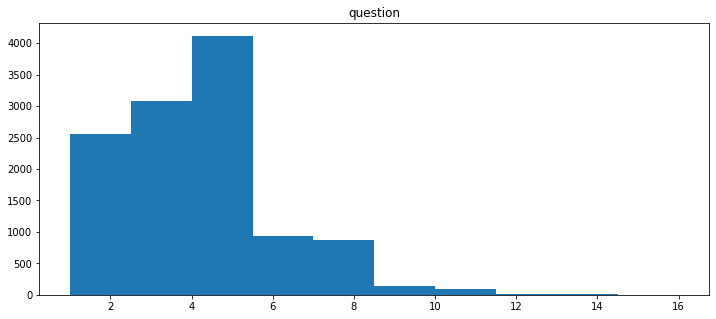

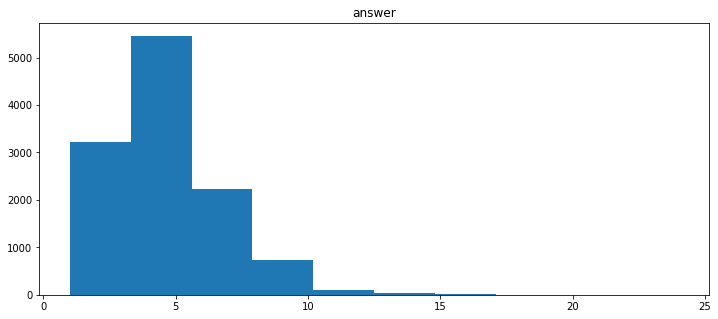

In [12]:
# Visualization
import matplotlib.pyplot as plt 

question_len = [len(s.split()) for s in questions]
answer_len = [len(s.split()) for s in answers]

print(max(question_len))
print(max(answer_len))

plt.figure(figsize=(12, 5))
plt.hist(question_len)
plt.title('question')

plt.figure(figsize=(12, 5))
plt.hist(answer_len)
plt.title('answer')

In [13]:
# Max length = 20 내외

MAX_LENGTH = 20

In [14]:
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
    
    for (sentence1, sentence2) in zip(inputs, outputs):
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
        
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
        
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(tokenized_outputs, maxlen=MAX_LENGTH, padding='post')        

    return tokenized_inputs, tokenized_outputs

In [15]:
questions, answers = tokenize_and_filter(questions, answers)

print('단어장 크기:', (VOCAB_SIZE))
print('필터링 후 질문 샘플 개수:{}'.format(len(questions)))
print('필터링 후 답변 샘플 개수:{}'.format(len(answers)))

단어장 크기: 8129
필터링 후 질문 샘플 개수:11793
필터링 후 답변 샘플 개수:11793


## 2. Teacher Forcing & Model Training

In [16]:
# Teacher Forcing
## 학생이 문제를 풀면 교사가 정답을 바로 알려주어 학습 용이도를 높이듯 모델에게도 적용함
## 실제 결과를 입력 레이블로 바로 입력하여 잘못된 순환 신경망(RNN) 예측을 예방하는 방법.

BATCH_SIZE = 64
BUFFER_SIZE = 20000

dataset = tf.data.Dataset.from_tensor_slices((
    {'inputs': questions,
    'dec_inputs':answers[:, :-1]},
    {'outputs': answers[:, 1:]}  # START_TOKEN 제외
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [17]:
# Model Training (Transformer)

## PositionalEncoding
class PositionalEncoding(tf.keras.layers.Layer):
    
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)
        
    def get_angles(self, position, i, d_model):
        angles = 1/tf.pow(10000, (2* (i//2))/ tf.cast(d_model, tf.float32))
        return position * angles
    
    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
                                    i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
                                    d_model=d_model)
        sines = tf.math.sin(angle_rads[:, 0::2]) # 짝수 인덱스
        cosines = tf.math.cos(angle_rads[:, 1::2]) # 홀수 인덱스
        
        pos_encoding = tf.concat([sines, cosines], axis= -1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        
        return tf.cast(pos_encoding, tf.float32)
    
    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

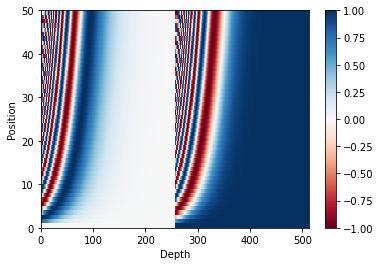

In [18]:
sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [19]:
## Scaled Dot Product Attention
def scaled_dot_product_attention(query, key, value, mask):
    matmul_qk = tf.matmul(query, key, transpose_b=True)
    
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)
    
    if mask is not None:
        logits += (mask * - 1e9)
    
    attention_weights = tf.nn.softmax(logits, axis=-1)
    output = tf.matmul(attention_weights, value)
    
    return output

In [20]:
## MultiHeadAttention
class MultiHeadAttention(tf.keras.layers.Layer):
    
    def __init__(self, d_model, num_heads, name='multi_head_attention'):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model
        
        assert d_model % self.num_heads == 0 
        
        self.depth = d_model // self.num_heads
        
        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)
        
        self.dense = tf.keras.layers.Dense(units=d_model)
    
    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])
    
    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]
        
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)
        
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)
        
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        
        outputs = self.dense(concat_attention)
        
        return outputs

In [21]:
## Padding
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    return mask[:, tf.newaxis, tf.newaxis, :] # [batch_size, 1, 1, sequence_length]

In [22]:
print(create_padding_mask(tf.constant([[1, 2, 3, 4, 5], [0, 1, 2, 3, 4]])))

tf.Tensor(
[[[[0. 0. 0. 0. 0.]]]


 [[[1. 0. 0. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


In [23]:
## Create Look Ahead Masking (0 -> 1)
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

In [24]:
print(create_look_ahead_mask(tf.constant([[5, 4, 3, 2, 1]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 0. 1. 1.]
   [0. 0. 0. 0. 1.]
   [0. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


In [25]:
## Encoder
def encoder_layer(units, d_model, num_heads, dropout, name='encoder_layer'):
    inputs = tf.keras.Input(shape=(None, d_model), name='inputs')
    
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
    
    attention = MultiHeadAttention(d_model, num_heads, name='attention')({
        'query':inputs, 'key':inputs, 'value':inputs, 'mask':padding_mask
    })
    
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)
    
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)
    
    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [26]:
def encoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name='encoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
    
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
                                
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
                                
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)
                                
    for i in range(num_layers):
        outputs = encoder_layer(units=units, d_model=d_model, num_heads=num_heads, dropout=dropout, name='encoder_layer_{}'.format(i),)([outputs, padding_mask])
    
    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [27]:
## Decoder
def decoder_layer(units, d_model, num_heads, dropout, name='decoder_layer'):
    inputs = tf.keras.Input(shape=(None, d_model), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
    
    attention1 = MultiHeadAttention(d_model, num_heads, name='attention_1')(inputs={
        'query':inputs, 'key':inputs, 'value':inputs, 'mask':look_ahead_mask
    })
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs)
    
    attention2 = MultiHeadAttention(d_model, num_heads, name='attention_2')(inputs={
        'query':attention1, 'key':enc_outputs, 'value':enc_outputs, 'mask':padding_mask
    })
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention2 + attention1)
    
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention2)
    
    return tf.keras.Model(inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask], outputs=outputs, name=name)

In [28]:
def decoder(vocab_size, num_layers, units, d_model,num_heads, dropout, name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')
    
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
    
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)
    
    for i in range(num_layers):
        outputs = decoder_layer(units=units, d_model=d_model, num_heads=num_heads, dropout=dropout, name='decoder_layer_{}'.format(i),)(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])
    
    return tf.keras.Model(inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask], outputs=outputs, name=name)

In [29]:
## Model (Transformer)
def transformer(vocab_size, num_layers,
               units, d_model, num_heads, dropout, name='transformer'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    dec_inputs = tf.keras.Input(shape=(None,), name='dec_inputs')
    # encoder에서 패딩 마스크
    enc_padding_mask = tf.keras.layers.Lambda(create_padding_mask, output_shape=(1, 1, None), name='enc_padding_mask')(inputs)
    # decoder에서 미래 토큰 마스크, 패딩 마스크
    look_ahead_mask = tf.keras.layers.Lambda(create_look_ahead_mask, output_shape=(1, None, None), name='look_ahead_mask')(dec_inputs)
    # 두번째 어텐션 블록에서 encoder의 벡터들을 마스킹, decoder에서 패딩 마스크
    dec_padding_mask = tf.keras.layers.Lambda(create_padding_mask, output_shape=(1, 1, None), name='dec_padding_mask')(inputs)
    
    # encoder
    enc_outputs = encoder(vocab_size=vocab_size, num_layers=num_layers, units=units, d_model=d_model, num_heads=num_heads, dropout=dropout)(inputs=[inputs, enc_padding_mask])
    # decoder
    dec_outputs = decoder(vocab_size=vocab_size, num_layers=num_layers, units=units, d_model=d_model, num_heads=num_heads, dropout=dropout)(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])
    
    # dense layer
    outputs = tf.keras.layers.Dense(units=vocab_size, name='outputs')(dec_outputs)
    
    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [30]:
## Model Summary
tf.keras.backend.clear_session()

NUM_LAYERS = 2  # encoder, decoder의 층 개수
D_MODEL = 256   # encoder, decoder 내부의 입/출력 고정 차원
NUM_HEADS = 8   # 멀티 헤드 어텐션의 헤드 수 
UNITS = 512     # feed forward 신경망 은닉층의 크기
DROPOUT = 0.1

model = transformer(vocab_size=VOCAB_SIZE, 
                   num_layers=NUM_LAYERS,
                   d_model=D_MODEL,
                   num_heads=NUM_HEADS,
                   units=UNITS,
                   dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3135232     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [31]:
## Loss Function
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH-1))
    
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')(y_true, y_pred)
    
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)
    
    return tf.reduce_mean(loss)

## Custom Learning Rate Scheduling
### Source: Keras documentation
    ### https://keras.io/api/callbacks/learning_rate_scheduler/
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        
        self.warmup_steps = warmup_steps
        
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)
        
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

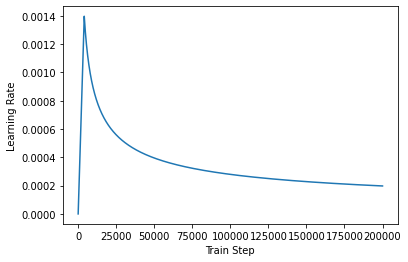

In [32]:
## Sample Visualization
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

In [33]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH -1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [34]:
## Model Training
## Epoch 25 => Accuracy 33%

EPOCHS = 50
history = model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/50
185/185 [==============================] - 13s 37ms/step - loss: 2.9681 - accuracy: 0.0496
Epoch 2/50
185/185 [==============================] - 7s 37ms/step - loss: 2.3957 - accuracy: 0.1017
Epoch 3/50
185/185 [==============================] - 7s 37ms/step - loss: 2.0479 - accuracy: 0.1037
Epoch 4/50
185/185 [==============================] - 7s 37ms/step - loss: 1.8930 - accuracy: 0.1111
Epoch 5/50
185/185 [==============================] - 7s 38ms/step - loss: 1.7740 - accuracy: 0.1177
Epoch 6/50
185/185 [==============================] - 7s 37ms/step - loss: 1.6529 - accuracy: 0.1260
Epoch 7/50
185/185 [==============================] - 7s 38ms/step - loss: 1.5189 - accuracy: 0.1383
Epoch 8/50
185/185 [==============================] - 7s 38ms/step - loss: 1.3709 - accuracy: 0.1543
Epoch 9/50
185/185 [==============================] - 7s 37ms/step - loss: 1.2114 - accuracy: 0.1720
Epoch 10/50
185/185 [==============================] - 7s 37ms/step - loss: 1.0464 - accur

## 3. Model Evaluation

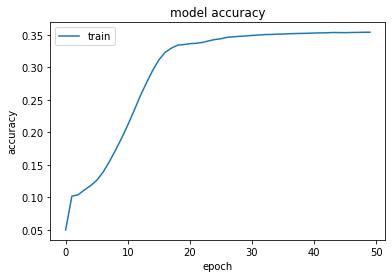

In [35]:
import matplotlib.pyplot as plt

# Model Accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

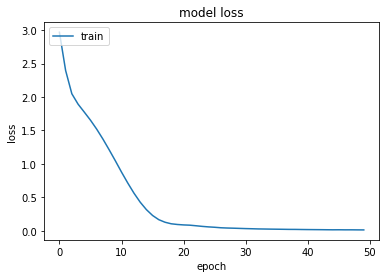

In [36]:
# Model Loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [37]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)
    
    sentence = tf.expand_dims(START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)
    
    output_sequence = tf.expand_dims(START_TOKEN, 0)
    
    for i in range(MAX_LENGTH):
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]
        
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
        
        if tf.equal(predicted_id, END_TOKEN[0]): # 종료토큰 나오면 예측 종료
            break
            
        # 다시 디코더의 입력이 된다. 
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)
        
    return tf.squeeze(output_sequence, axis=0)

In [38]:
def sentence_generation(sentence):
    prediction = decoder_inference(sentence)
    predicted_sentence = tokenizer.decode([i for i in prediction if i < tokenizer.vocab_size])
    
    print('문의 내용 : {}'.format(sentence))
    print('답변 내용 : {}'.format(predicted_sentence))    
    
    return predicted_sentence

In [39]:
# Test_1
sentence_generation('내 미래의 날씨는 어때?')

문의 내용 : 내 미래의 날씨는 어때?
답변 내용 : 사랑은 강요하는게 아니에요 .


'사랑은 강요하는게 아니에요 .'

In [40]:
# Test_2
sentence_generation('인간의 본성이란?')

문의 내용 : 인간의 본성이란?
답변 내용 : 잘하는 것도 많아요 .


'잘하는 것도 많아요 .'

In [41]:
# Test_3
sentence_generation('형주가 코로나 상황에도 공부해야 된대. 불쌍하지 않니?')

문의 내용 : 형주가 코로나 상황에도 공부해야 된대. 불쌍하지 않니?
답변 내용 : 천천히 로 다가가고 알아가야죠 .


'천천히 로 다가가고 알아가야죠 .'

In [42]:
# Test_4
sentence_generation('거울아 거울아 누가 제일 멋있니?')

문의 내용 : 거울아 거울아 누가 제일 멋있니?
답변 내용 : 사랑의 콩깍지가 씌었네요 .


'사랑의 콩깍지가 씌었네요 .'

In [43]:
# Test_5
sentence_generation('사랑이란 무엇일까?')

문의 내용 : 사랑이란 무엇일까?
답변 내용 : 사랑에는 조건도 중요한 요 .


'사랑에는 조건도 중요한 요 .'

## 4. Project Retrospective

+ 한국어의 형태소 분석기가 없어도, Tokenization이 가능하다는 점을 배웠다.
+ Teacher Forcing의 개념을 익혀 직접 적용한 첫 프로젝트였다.
+ 한국어 전처리로 나름 정확한 결과를 구현해낸 것이 신기하고, 이를 통해 단순 문의에 대해서는 상담 자동화도 가능하겠다는 점을 보았다.